<a href="https://colab.research.google.com/github/paddydoc/paddy-doctor-dataset/blob/main/notebooks/cnn_diseases_small_400_split_epoch100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook demonstrates how to develop a simple deep CNN model for paddy disease classition using Keras.

### Sections of this notebook
1. [Setup environment and import datasets](#setup)
2. [Import libraries](#import)
3. [Dataset preparation](#dataset)
3. [Define a deep CNN model](#model)
4. [Model training](#train)
5. [Model testing](#test)
6. [Results](#results)

<a name="setup"></a>
### 1. Setup environment and import datasets


<!-- ####  a. Import dataset

1. Download the Paddy Doctor split balanced dataset file ``paddy-doctor-diseases-small-400-split.zip`` from [this link](https://ieee-dataport.org/documents/paddy-doctor-visual-image-dataset-automated-paddy-disease-classification-and-benchmarking)
2. Create a new folder named ``paddy-doctor`` in your Google Drive's root directory and upload the ``paddy-doctor-diseases-small-400-split.zip`` file there. -->

#### b. Mount Google Drive


In [ ]:
# ## mount google drive
# from google.colab import drive
# drive.mount('/content/drive')
# !pwd

In [ ]:
# %cd /content/drive/MyDrive/paddy-doctor
# !ls -l

#### c. Extract the datset files

In [ ]:
# ## skip this command, if you already have extracted the files
# #!unzip -qq paddy-doctor-diseases-small-splitted.zip
# !unzip -qq paddy-doctor-diseases-small-400-split.zip

##### The ``paddy-doctor`` folder should contains the following directories and files.

In [ ]:
# !ls -l
# !find ./train -type f -print | wc -l
# !find ./test -type f -print | wc -l

<a name="import"></a>
### 2. Import python *libraries*


#### Verify the files in the train and test directories

In [ ]:
import glob
from pathlib import Path

## Google Colab (See the above instructions)
# train_path = '/content/drive/MyDrive/paddy-doctor/train/'
# test_path  = '/content/drive/MyDrive/paddy-doctor/test/'

## Kaggle (create a new dataset with a path "paddy-doctor-diseases-small-400-split" using paddy-doctor-diseases-small-400-split.zip

train_path = '/kaggle/input/paddy-doctor-diseases-small-400-split/train/'
test_path  = '/kaggle/input/paddy-doctor-diseases-small-400-split/test/'

print('training set')
for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

print('testing set')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

training set
320 	 tungro
320 	 yellow_stem_borer
320 	 hispa
320 	 downy_mildew
320 	 black_stem_borer
320 	 bacterial_leaf_streak
320 	 bacterial_leaf_blight
320 	 brown_spot
320 	 blast
320 	 leaf_roller
320 	 normal
320 	 bacterial_panicle_blight
320 	 white_stem_borer
testing set
80 	 tungro
80 	 yellow_stem_borer
80 	 hispa
80 	 downy_mildew
80 	 black_stem_borer
80 	 bacterial_leaf_streak
80 	 bacterial_leaf_blight
80 	 brown_spot
80 	 blast
80 	 leaf_roller
80 	 normal
80 	 bacterial_panicle_blight
80 	 white_stem_borer


#### Import the necesary python libraries

In [ ]:
import os
import random
from os import listdir
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend

import matplotlib.pyplot as plt

SEED = 1234
def set_seed(seed=SEED):
    np.random.seed(seed) 
    tf.random.set_seed(seed) 
    random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    os.environ['TF_CUDNN_DETERMINISM'] = "1"
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

# from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils import plot_model

# from keras.layers.core import Activation, Flatten, Dropout, Dense

# from tensorflow.keras.layers import BatchNormalization
# from keras.layers.convolutional import Conv2D
# from keras.layers.convolutional import MaxPooling2D
# from keras.layers.core import Activation, Flatten, Dropout, Dense
# from keras import backend as K
# from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils import plot_model
# from keras.callbacks import ModelCheckpoint, EarlyStopping

# from keras.preprocessing import image
# #from keras.preprocessing.image import img_to_array
# from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt


# from os import listdir
# from sklearn.preprocessing import LabelBinarizer
# from tensorflow.keras.models import Sequential

# from tensorflow.keras.layers import BatchNormalization
# from keras.layers.convolutional import Conv2D
# from keras.layers.convolutional import MaxPooling2D
# from keras.layers.core import Activation, Flatten, Dropout, Dense
# from keras import backend as K
# from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils import plot_model
# from keras.callbacks import ModelCheckpoint, EarlyStopping

# from keras.preprocessing import image
# #from keras.preprocessing.image import img_to_array
# from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.model_selection import train_test_split
# from psutil import virtual_memory

##### Define the necessary **constants**

In [ ]:
SEED = 1234
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
width = 256
height = 256
depth = 3

n_classes = len(glob.glob(train_path + '/*/'))
print(n_classes)

13


<a name="dataset"></a>
### 3. Dataset preparation (train, validate, and test sets)

#### 3a. Setup **ImageDataGenerator** with different image transformation options to generate diverse training samples.


> Note that 20% of training samples are reserved as validattion set (See ``validation_split=0.2``)


In [ ]:
image_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 shear_range=0.2,
                 zoom_range=0.2,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1./255,
                 validation_split=0.2)

#### 3b. Next, let's configure the train, validate, and test data generators using ``flow_from_directory``

In [ ]:
train_generator = image_datagen.flow_from_directory(    
    directory = train_path,
    subset='training',
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=SEED)

valid_generator = image_datagen.flow_from_directory(    
    directory=train_path,
    subset='validation',
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=SEED)
print(train_generator.class_indices)
print(train_generator.samples)

Found 3328 images belonging to 13 classes.
Found 832 images belonging to 13 classes.
{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'black_stem_borer': 3, 'blast': 4, 'brown_spot': 5, 'downy_mildew': 6, 'hispa': 7, 'leaf_roller': 8, 'normal': 9, 'tungro': 10, 'white_stem_borer': 11, 'yellow_stem_borer': 12}
3328


<a name="model"></a>
### 4. CNN model


##### 4a. Define the layers of a simple CNN model

In [ ]:
def get_model():
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    print(backend.image_data_format())
    if backend.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1
    model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(n_classes))
    model.add(Activation("softmax"))
    
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    # distribution
    model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
    return model

#### 4b. Plot the CNN model

2022-11-29 19:59:51.882821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 19:59:52.053020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 19:59:52.053838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 19:59:52.055677: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

channels_last


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


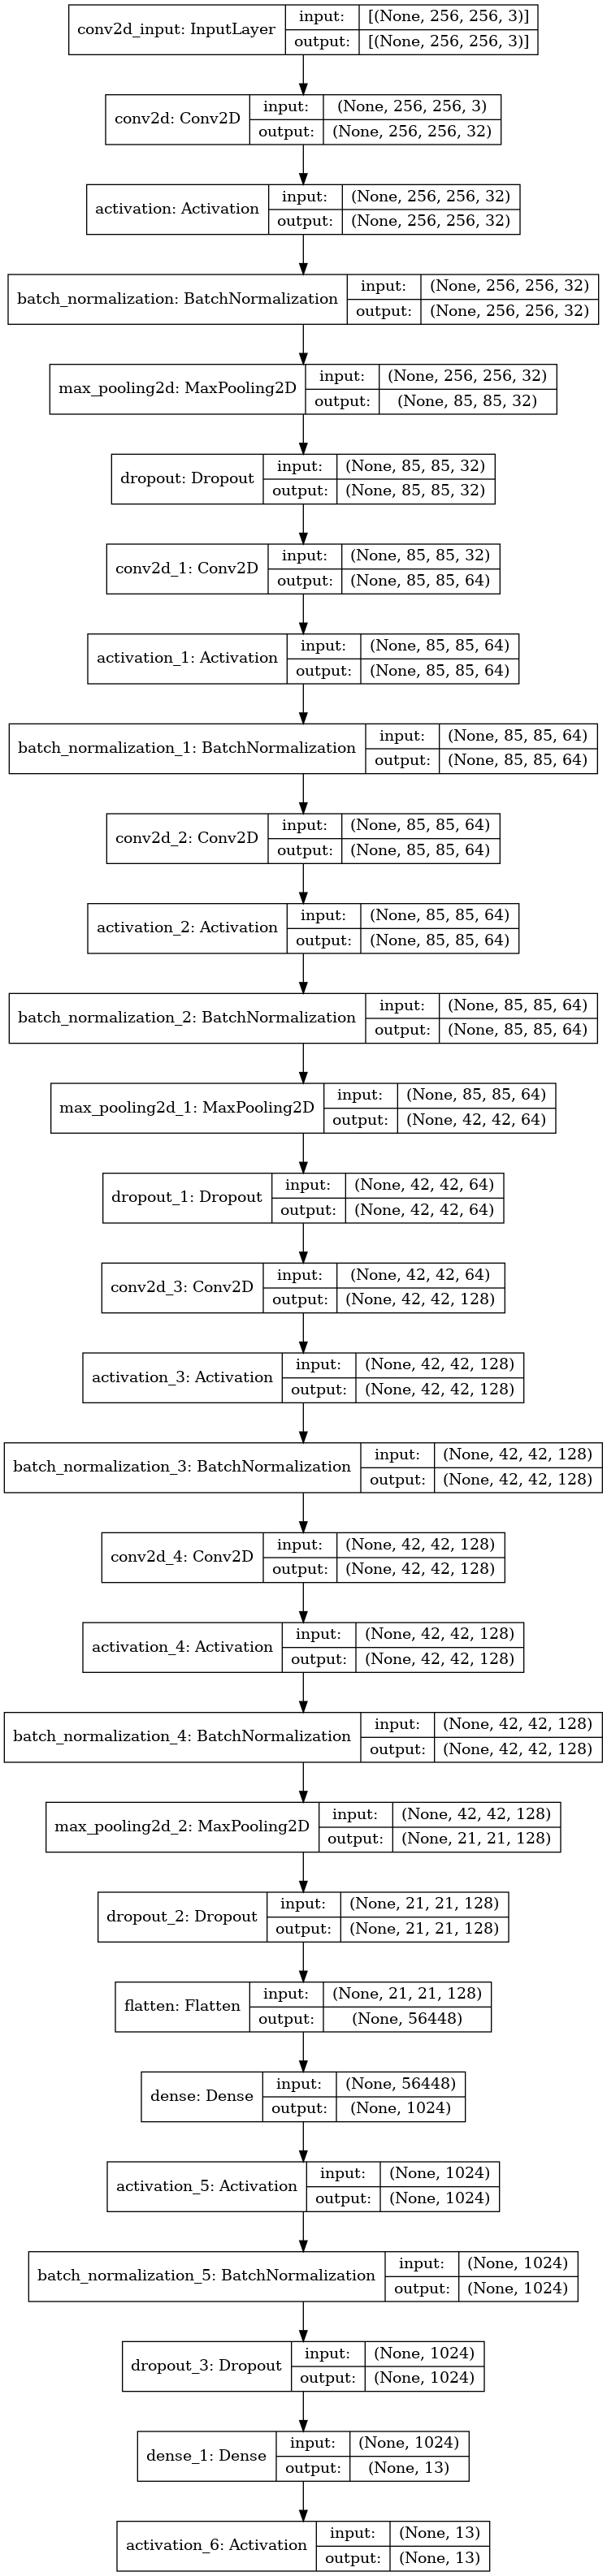

In [ ]:
model = get_model()
plot_model(model, 'cnn-model.png', show_shapes=True)

<a name="`train`"></a>
### 5. Model training


#### 5a. (Optional) Setup and configure training checkpoints, early stopping, and ploting call backs to lively visualize the traiing

In [ ]:
#!pip install livelossplot

In [ ]:
try:
    import livelossplot
except:
    !pip install livelossplot    

from livelossplot.inputs.keras import PlotLossesCallback

plot_loss = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
checkpoint = ModelCheckpoint(filepath='paddy-doctor-small-cnn.best.hdf5',
                             save_best_only=True,
                             verbose=1)
# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

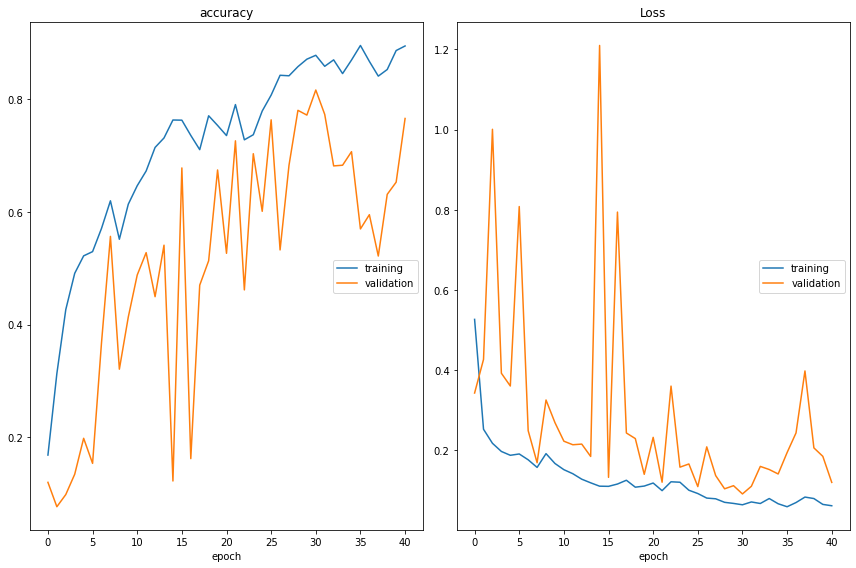

accuracy
	training         	 (min:    0.169, max:    0.895, cur:    0.894)
	validation       	 (min:    0.077, max:    0.816, cur:    0.766)
Loss
	training         	 (min:    0.059, max:    0.527, cur:    0.062)
	validation       	 (min:    0.091, max:    1.210, cur:    0.120)
CPU times: user 46min 44s, sys: 51.6 s, total: 47min 35s
Wall time: 45min 23s


In [ ]:
%%time
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = STEP_SIZE_TRAIN,
                              validation_steps = STEP_SIZE_VALID,
                              validation_data = valid_generator,
                              callbacks=[checkpoint, early_stop, plot_loss],
                              epochs=EPOCHS,
                              verbose=1)

#### 5a. Plot the training performance (accuracy and loss)

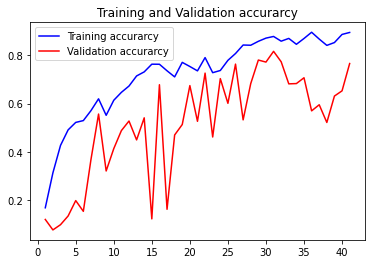

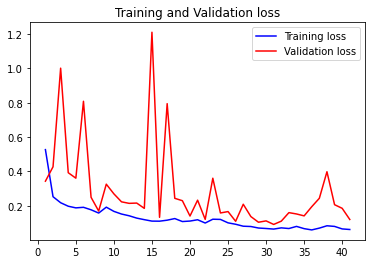

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

<a name="test"></a>
### 6. Model testing


#### 6a. Verify test directory




In [ ]:
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

class_subset = sorted(os.listdir(test_path))
class_subset

80 	 tungro
80 	 yellow_stem_borer
80 	 hispa
80 	 downy_mildew
80 	 black_stem_borer
80 	 bacterial_leaf_streak
80 	 bacterial_leaf_blight
80 	 brown_spot
80 	 blast
80 	 leaf_roller
80 	 normal
80 	 bacterial_panicle_blight
80 	 white_stem_borer


['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'black_stem_borer',
 'blast',
 'brown_spot',
 'downy_mildew',
 'hispa',
 'leaf_roller',
 'normal',
 'tungro',
 'white_stem_borer',
 'yellow_stem_borer']

#### 6b. Define a test data generator

In [ ]:
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(    
    directory=test_path,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    classes=class_subset,
    #classes=['.'],
    class_mode=None,
    shuffle=False,
    seed=SEED)

class_names = test_generator.class_indices.keys()
true_classes = test_generator.classes

Found 1040 images belonging to 13 classes.


#### 6c. Model predition

In [ ]:
model.load_weights('paddy-doctor-small-cnn.best.hdf5') # initialize the best trained weights
pred = model.predict(test_generator)
pred_classes = np.argmax(pred, axis=1)

<a name="results"></a>
### 7. Results

#### 7a. Calculate and print classification report

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

acc = accuracy_score(true_classes, pred_classes)
print("CNN Model accuracy: {:.2f}%".format(acc * 100))

cls_report = classification_report(true_classes, pred_classes, 
                                   target_names=class_names, digits=5)
print(cls_report)

CNN Model accuracy: 83.46%
                          precision    recall  f1-score   support

   bacterial_leaf_blight    0.77907   0.83750   0.80723        80
   bacterial_leaf_streak    0.87640   0.97500   0.92308        80
bacterial_panicle_blight    0.83696   0.96250   0.89535        80
        black_stem_borer    0.93151   0.85000   0.88889        80
                   blast    0.89831   0.66250   0.76259        80
              brown_spot    0.89394   0.73750   0.80822        80
            downy_mildew    0.88235   0.93750   0.90909        80
                   hispa    0.81250   0.65000   0.72222        80
             leaf_roller    0.85714   0.82500   0.84076        80
                  normal    0.80952   0.85000   0.82927        80
                  tungro    0.67368   0.80000   0.73143        80
        white_stem_borer    0.85526   0.81250   0.83333        80
       yellow_stem_borer    0.80851   0.95000   0.87356        80

                accuracy                       

#### 7b. Plot and print confustion matrix

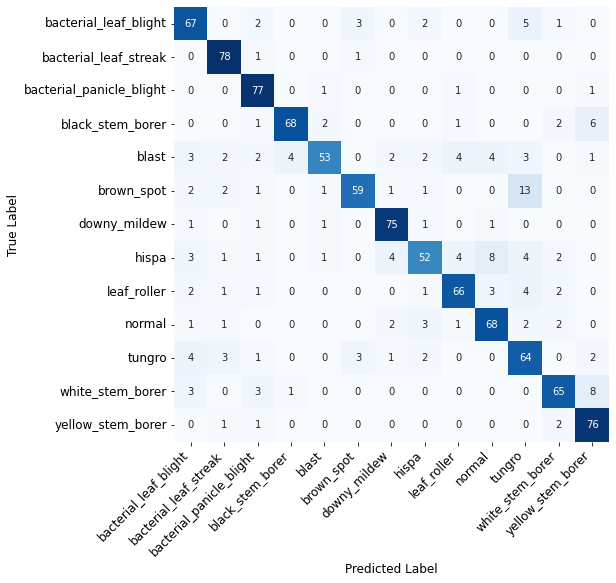

[[67  0  2  0  0  3  0  2  0  0  5  1  0]
 [ 0 78  1  0  0  1  0  0  0  0  0  0  0]
 [ 0  0 77  0  1  0  0  0  1  0  0  0  1]
 [ 0  0  1 68  2  0  0  0  1  0  0  2  6]
 [ 3  2  2  4 53  0  2  2  4  4  3  0  1]
 [ 2  2  1  0  1 59  1  1  0  0 13  0  0]
 [ 1  0  1  0  1  0 75  1  0  1  0  0  0]
 [ 3  1  1  0  1  0  4 52  4  8  4  2  0]
 [ 2  1  1  0  0  0  0  1 66  3  4  2  0]
 [ 1  1  0  0  0  0  2  3  1 68  2  2  0]
 [ 4  3  1  0  0  3  1  2  0  0 64  0  2]
 [ 3  0  3  1  0  0  0  0  0  0  0 65  8]
 [ 0  1  1  0  0  0  0  0  0  0  0  2 76]]


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_heatmap(true_classes, pred_classes, class_names, ax, title="CNN")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()
cm = confusion_matrix(true_classes, pred_classes)
print(cm)